<a href="https://colab.research.google.com/github/shiamabdullah/genre_predict/blob/main/Movie_Genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the required libraries


In [ ]:
import json
import nltk
import re
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Loading Data from dataset.
Name: CMU Movie Summary Corpus 
Link: http://www.cs.cmu.edu/~ark/personas/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/My Drive/Dataset Movies/movie.metadata.tsv"
meta = pd.read_csv(file_path, sep = '\t', header = None)

In [ ]:
meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Removing unnecessary columns:
We need only 3 columns. Others can be removed from th df. Necessary columns are 0 (unique id), 2(name), 8(genre)

In [ ]:
meta.drop([1,3,4,5,6,7], axis = 1, inplace = True) 
meta.head()


,0,2,8
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,Brun bitter,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,A Woman in Flames,"{""/m/07s9rl0"": ""Drama""}"


In [ ]:
meta.columns = ["movie_id","movie_name","genre"]

In [ ]:
meta.head()


,movie_id,movie_name,genre
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,Brun bitter,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,A Woman in Flames,"{""/m/07s9rl0"": ""Drama""}"


##Making another dataset from summaries


1.   Load file
2.   List plot files with corresponding id


###Loading plot file
This data is text file with each row consisting a pair of a movie id and a plot of the movie. 
Read it line by line


In [ ]:
file_path_2 = "/content/drive/My Drive/Dataset Movies/plot_summaries.txt"
plot_summaries = []

with open(file_path_2, 'r') as f:
    reader = csv.reader(f, dialect='excel-tab') 
    for row in tqdm(reader):
        plot_summaries.append(row)

42303it [00:02, 20437.55it/s]


###Making another df of summaries

In [ ]:
movie_id = []
plot = []

for i in tqdm(plot_summaries):
    movie_id.append(i[0])
    plot.append(i[1])

100%|██████████| 42303/42303 [00:00<00:00, 1309825.94it/s]


In [ ]:
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})

In [ ]:
movies.head()

,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


###Making new df

In [ ]:
meta['movie_id'] = meta['movie_id'].astype(str)
movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

In [ ]:
movies.head()

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


# Cleaning The Dataframe
  

## converting genre to list from dict

In [ ]:
type(json.loads(movies['genre'][0]))



{"/m/07s9rl0": "Drama", "/m/03q4nz": "World cinema"} <class 'dict'>


dict

In [ ]:
json.loads(movies['genre'][0]).values()

dict_values(['Drama', 'World cinema'])

dict_values(['Drama', 'World cinema'])

In [ ]:
genres = []

for i in movies['genre']:
  genres.append(list(json.loads(i).values()))
    
movies['genre_new'] = genres

##Clean things that don't contain genre

In [ ]:
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

In [ ]:
movies_new.shape, movies.shape

((41793, 5), (42204, 5))

411 samples without genre 

In [ ]:
movies_new.head()

,movie_id,plot,movie_name,genre,genre_new
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","[Drama, World cinema]"
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...","[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...","[Screwball comedy, Comedy]"
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","[Crime Fiction, Drama, Docudrama, World cinema..."


### Removing the previous genre tag now and renaming new genre as genre


In [ ]:
movies_new.drop(['genre'], axis = 1, inplace = True) 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
movies_new.head()

,movie_id,plot,movie_name,genre_new
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"[Drama, World cinema]"
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"[Screwball comedy, Comedy]"
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"[Crime Fiction, Drama, Docudrama, World cinema..."


Keeping a copy of the dataset


In [ ]:
movies_new.to_csv('/content/drive/My Drive/Dataset Movies/DataSetCLEAN.csv')

# Data Analysis


##Uniqye Genre

Getting Types of unique Genres


```
all_genres = sum(genres,[])
len(set(all_genres))

```



In [ ]:
all_genres
len(set(all_genres))

363

## Frequency


In [ ]:
all_genres = nltk.FreqDist(all_genres)
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Count': list(all_genres.values())})

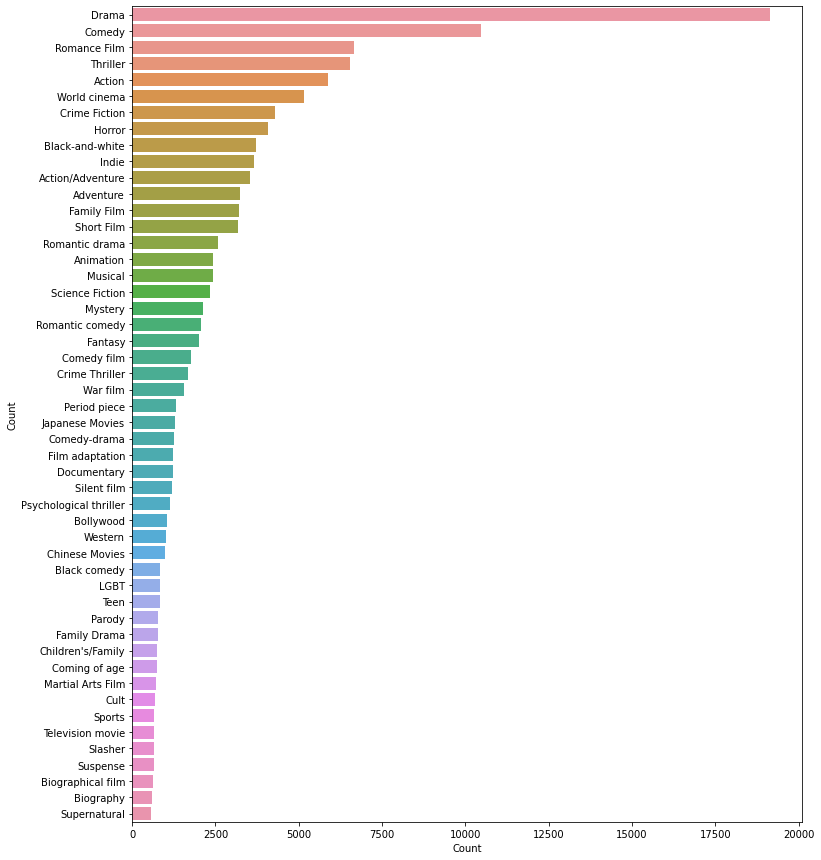

In [ ]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Genre")
ax.set(ylabel = 'Count')
plt.show()

##Cleaning Text
  This can be updated more.
  Shahil checkout this [link for cleaning](https://monkeylearn.com/blog/text-cleaning/)

In [ ]:
def clean_text(text):
    text = re.sub("\'", "", text)       #backslash-apostrophe
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
      #We tell our program to eliminate the punctuation, URL, and @:

    text = re.sub("[^a-zA-Z]"," ",text)    # alpha-numeric
    text = ' '.join(text.split())       # remove whitespaces
    text = text.lower()     # convert text to lowercase
    
    return text

Applying method

In [ ]:
movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
movies_new[['clean_plot', 'plot']].sample(3)

,clean_plot,plot
14226,at the beginning the narrator explains how clo...,"At the beginning, the narrator explains how cl..."
36242,a boy peered out the window of his house a pas...,A boy peered out the window of his house. A pa...
20306,a henpecked politician wants his name attached...,A henpecked politician wants his name attached...


### Frequeny Words


In [ ]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(12,15))
  ax = sns.barplot(data=d, x= "count", y = "word")
  ax.set(ylabel = 'Word')
  plt.show()

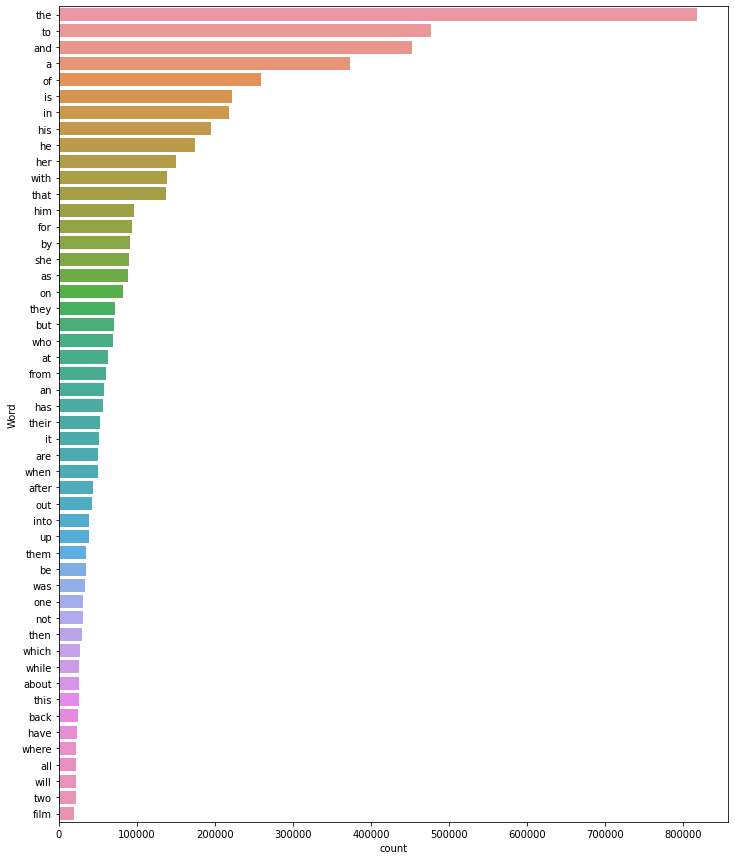

In [ ]:
freq_words(movies_new['clean_plot'], 50)

### Removing Stopwords 


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


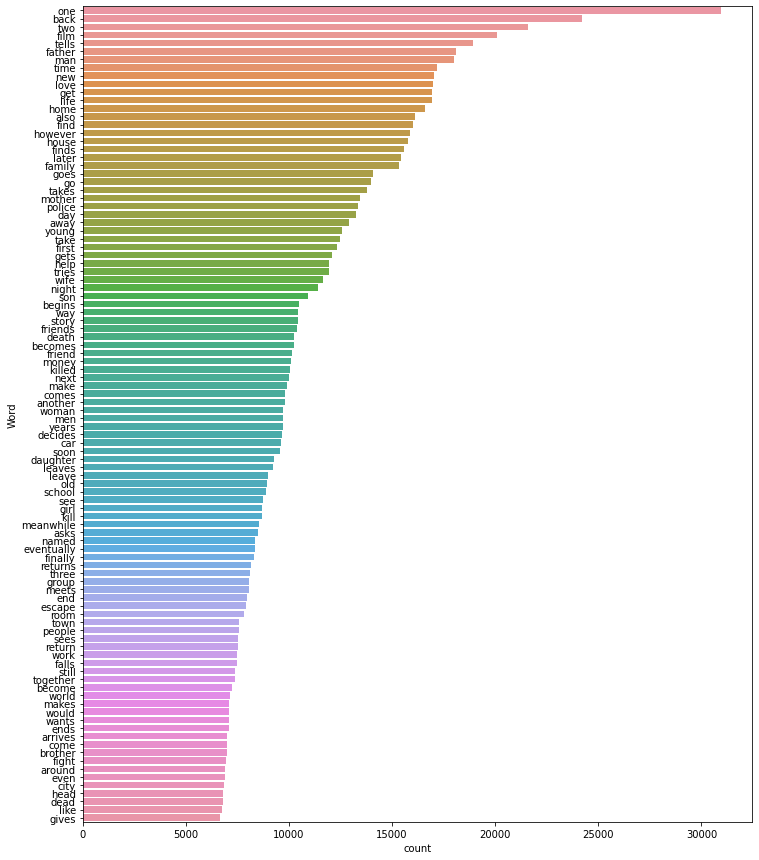

In [ ]:
freq_words(movies_new['clean_plot'], 100)

#Feature Extract

## MUltilable Binarizer and feature

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

y = multilabel_binarizer.transform(movies_new['genre_new'])

Will try word 2 vector later on, Here Used tf_idf




In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

##Splitting to test train

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=9)

create features for the train and the validation set.

In [ ]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

# Prediction Model

## Train

In [ ]:
from sklearn.linear_model import LogisticRegression

# Binary 
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [ ]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [ ]:
clf.fit(xtrain_tfidf, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 48 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 182 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 214 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 245 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

OneVsRestClassifier(estimator=LogisticRegression())

In [ ]:
y_pred = clf.predict(xval_tfidf)

In [ ]:
y_pred[3]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Convertig to genre from binary

Returns binary one dimensional array of length 363. It is the one hot encoded form of the unique genre tags. 
We have used **inverse_transform( )** function along with the MultiLabelBinarizer( ) object to convert the predicted arrays into movie genre tags.

In [ ]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('Action', 'Drama')

In [ ]:
f1_score(yval, y_pred, average="micro")

0.3136723048184447

## Tuning **Performance**

In [ ]:
y_pred_prob = clf.predict_proba(xval_tfidf)

Setting a new thrshhold value

In [ ]:
t = 0.2
y_pred_new = (y_pred_prob >= t).astype(int)

In [ ]:
f1_score(yval, y_pred_new, average="micro")

0.4677185529820303

i have checked it with rangr from .2 to .3. However we can use k-fold later on

## Function All in one

Making a function which will do all in one for future data's

In [ ]:
def predict_genre(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [ ]:
for i in range(10):
    k = xval.sample(1).index[0]
    print("Movie: ", movies_new['movie_name'][k], "\nPredicted genre: ", predict_genre(xval[k])), print("Actual genre: ",movies_new['genre_new'][k], "\n")   

Movie:  Remo Williams: The Adventure Begins 
Predicted genre:  [('Action', 'Action/Adventure', 'Thriller')]
Actual genre:  ['Crime Fiction', 'Adventure', 'Action/Adventure', 'Glamorized Spy Film', 'Martial Arts Film', 'Comedy', 'Action', 'Spy'] 

Movie:  Boy! What a Girl! 
Predicted genre:  [()]
Actual genre:  ['Musical', 'Comedy', 'Black-and-white'] 

Movie:  A Chinese Ghost Story II 
Predicted genre:  [('World cinema',)]
Actual genre:  ['Horror', 'World cinema', 'Action/Adventure', 'Fantasy', 'Martial Arts Film', 'Drama', 'Comedy', 'Romantic drama', 'Romance Film', 'Action', 'Chinese Movies'] 

Movie:  Turning 30 
Predicted genre:  [('Comedy',)]
Actual genre:  ['Romantic comedy', 'Romance Film', 'Comedy', 'World cinema'] 

Movie:  Stand by for Action 
Predicted genre:  [('Drama', 'War film')]
Actual genre:  ['Combat Films', 'Adventure', 'Black-and-white', 'War film'] 

Movie:  The Moon's Our Home 
Predicted genre:  [('Comedy', 'Romance Film', 'Romantic comedy')]
Actual genre:  ['Roma